In [131]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
from sklearn.model_selection import train_test_split

import math

from sklearn.linear_model import ElasticNet

In [132]:
# Current script
current_path = os.getcwd()

# Add utils folder to sys path 
sys.path.append(os.path.join(current_path, "utils"))

# Import the prewritten helper functions
from py_helper_functions import *

# Data

In [133]:
# Read the data
data = pd.read_csv("https://raw.githubusercontent.com/00Dabide/DA3-Assignment-2/main/listings.csv")
data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,38768,https://www.airbnb.com/rooms/38768,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.75 · 1 bedroom · 3 ...,NaN,the Karmeliterviertel became very popular in t...,https://a0.muscache.com/pictures/ad4089a3-5355...,166283,...,4.94,4.77,4.70,NaN,t,3,3,0,0,2.48
1,40625,https://www.airbnb.com/rooms/40625,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.85 · 2 bedrooms · 4...,NaN,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/11509144/d55c...,175131,...,4.94,4.59,4.72,NaN,t,15,14,1,0,1.24
2,51287,https://www.airbnb.com/rooms/51287,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.66 · Studio · 2 bed...,NaN,The neighbourhood has a lot of very nice littl...,https://a0.muscache.com/pictures/25163038/1c4e...,166283,...,4.95,4.86,4.59,NaN,f,3,3,0,0,2.36
3,70637,https://www.airbnb.com/rooms/70637,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.77 · 1 bedroom · 2 ...,NaN,NaN,https://a0.muscache.com/pictures/925691/c8c1bd...,358842,...,4.76,4.81,4.72,NaN,f,3,1,2,0,0.75
4,75500,https://www.airbnb.com/rooms/75500,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.45 · 2 bedrooms · 2...,NaN,NaN,https://a0.muscache.com/pictures/549090/b51ce4...,400857,...,4.67,4.08,4.42,NaN,f,1,1,0,0,0.08


In [134]:
# Basic infos

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14697 entries, 0 to 14696
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            14697 non-null  int64  
 1   listing_url                                   14697 non-null  object 
 2   scrape_id                                     14697 non-null  int64  
 3   last_scraped                                  14697 non-null  object 
 4   source                                        14697 non-null  object 
 5   name                                          14697 non-null  object 
 6   description                                   0 non-null      float64
 7   neighborhood_overview                         7553 non-null   object 
 8   picture_url                                   14697 non-null  object 
 9   host_id                                       14697 non-null 

# Cleaning

In [135]:
# Def "dummifier" function

# For self-created dummies (True/False)
def todummy(b):
    if b == True:
        return 1
    return 0

# For data dummies (t/f)
def todummy2(b):
    if b == "t":
        return 1
    return 0

In [136]:
# host_location may contain values, which are outside of Vienna, even Austria!!!
data["In_Austria"] = data["host_location"].str.contains("Vienna, Austria|Wien, Austria")
data = data.loc[data["In_Austria"] == True]
print(data["host_location"].value_counts())


# Only 2-6 people accommodations
data = data.loc[data["accommodates"].between(2,6)]


# Exclude Hotel rooms
data = data.loc[data["room_type"] != "Hotel room"]


# Only Rental unit or condo(basically apartment)
data = data[data["property_type"].str.contains("Entire rental unit|Private room in rental unit|Entire condo|Private room in condo") == True]

# Replace NA values
data.fillna(0, inplace=True)


# Replace currency price to float
data["price"] = data["price"].replace('[\$,]', '', regex=True).astype(float)


#Flags

# Has review (more than 0)
data["flag_number_of_reviews"] = data["number_of_reviews"] > 0

# Has a score of at least 3.5
data["flag_review_scores_rating"] = (data["review_scores_rating"] >= 3.5)


# Replace booleans to 1/0, so the program will be able to use it

data["flag_number_of_reviews"] = data["flag_number_of_reviews"].apply(todummy)
print(data["flag_number_of_reviews"].value_counts())
data["flag_review_scores_rating"] = data["flag_review_scores_rating"].apply(todummy)
print(data["flag_review_scores_rating"].value_counts())


data["host_is_superhost"] = data["host_is_superhost"].apply(todummy2)
print(data["host_is_superhost"].value_counts())
data["host_has_profile_pic"] = data["host_has_profile_pic"].apply(todummy2)
print(data["host_has_profile_pic"].value_counts())
data["host_identity_verified"] = data["host_identity_verified"].apply(todummy2)
print(data["host_identity_verified"].value_counts())
data["instant_bookable"] = data["instant_bookable"].apply(todummy2)
print(data["instant_bookable"].value_counts())

host_location
Vienna, Austria            9561
Wien, Austria               142
Baden bei Wien, Austria       4
Name: count, dtype: int64
flag_number_of_reviews
1    6975
0    1118
Name: count, dtype: int64
flag_review_scores_rating
1    6889
0    1204
Name: count, dtype: int64
host_is_superhost
0    5732
1    2361
Name: count, dtype: int64
host_has_profile_pic
1    8035
0      58
Name: count, dtype: int64
host_identity_verified
1    7233
0     860
Name: count, dtype: int64
instant_bookable
0    4455
1    3638
Name: count, dtype: int64


# 3 Different models:
- Linear OLS regression
- Random Forest
- LASSO

In [137]:
#train and test data
data_train, data_holdout = train_test_split(data, train_size=0.7, random_state=42)
data_train.shape, data_holdout.shape

((5665, 78), (2428, 78))

## Variables

In [138]:
# basic variables
basic_vars = [
    "accommodates", 
    "beds", 
    "property_type", 
    "room_type", 
    "bathrooms_text",
    "neighbourhood_cleansed", 
]

# reviews
reviews = [
    "number_of_reviews", 
    "flag_number_of_reviews", 
    "review_scores_rating",
    "flag_review_scores_rating",
]

# host dummy variables + instant_bookable dummy
host = [
    "host_is_superhost", 
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable", 
]

# interactions for the LASSO
# from ch14
X1 = [
    "accommodates:property_type", 
    "room_type:property_type", 
    "room_type:instant_bookable",
]
# with boroughs
X2 = [
    "property_type:neighbourhood_cleansed", 
    "room_type:neighbourhood_cleansed",
    "accommodates:neighbourhood_cleansed",
]

predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + host
predictors_E = basic_vars + reviews + host + X1 + X2

# OLS

In [139]:
# Models for lnw:

formula1 = "price ~ accommodates + beds + number_of_reviews + instant_bookable"
formula2 = "price ~ accommodates + beds + number_of_reviews + instant_bookable + property_type + room_type + flag_number_of_reviews + accommodates:property_type + neighbourhood_cleansed"
formula3 = "price ~ accommodates + beds + number_of_reviews + instant_bookable + property_type + room_type + flag_number_of_reviews + accommodates:property_type + neighbourhood_cleansed + review_scores_rating + host_is_superhost + room_type:property_type + property_type:neighbourhood_cleansed"
formula4 = "price ~ accommodates + beds + number_of_reviews + instant_bookable + property_type + room_type + flag_number_of_reviews + accommodates:property_type + neighbourhood_cleansed + review_scores_rating + host_is_superhost + room_type:property_type + property_type:neighbourhood_cleansed + bathrooms_text + accommodates:neighbourhood_cleansed"

# Model1:
reg1 = smf.ols(formula=formula1, data=data).fit(cov_type = "HC0")

# Model2:
reg2 = smf.ols(formula=formula2, data=data).fit(cov_type = "HC0")

# Model3:
reg3 = smf.ols(formula=formula3, data=data).fit(cov_type = "HC0")

# Model4:
reg4 = smf.ols(formula=formula4, data=data).fit(cov_type = "HC0")

In [140]:
bic = [round(x.bic, 2) for x in [reg1,reg2,reg3,reg4]]
sg = stargazer.Stargazer([reg1,reg2,reg3,reg4])
sg.add_line('BIC', bic, location=stargazer.LineLocation.FOOTER_BOTTOM)

sg

In [141]:
#get models rmse

print("Model 1:", rmse(reg1.fittedvalues,data.price))
print("Model 2:", rmse(reg2.fittedvalues,data.price))
print("Model 3:", rmse(reg3.fittedvalues,data.price))
print("Model 4:", rmse(reg4.fittedvalues,data.price))

Model 1: 111.78035373463207
Model 2: 108.73162290034043
Model 3: 107.76978172262346
Model 4: 106.27141215091032


# Random Forest

In [142]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

In [143]:
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 7.35.


In [144]:
rfr = RandomForestRegressor(random_state = 20240129)
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [145]:
%%time
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-63.103 total time=   0.5s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-69.335 total time=   0.4s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-62.190 total time=   0.4s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-68.073 total time=   0.4s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-71.367 total time=   0.4s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-64.143 total time=   0.3s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-70.546 total time=   0.3s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-63.221 total time=   0.3s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-69.749 total time=   0.2s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-72.633 total time=   0.3s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-65.025 total time=   0.2s
[CV 2/5] END max_features=6, min_samples_leaf=15;, score=-71.201 total time=   0.

In [146]:
rf_model.cv_results_

{'mean_fit_time': array([0.47134848, 0.378581  , 0.30575247, 0.55313292, 0.42678757,
        0.3859838 , 0.65608191, 0.50238323, 0.42885575, 0.72905383,
        0.54872365, 0.50916524]),
 'std_fit_time': array([0.04856859, 0.03398131, 0.01843422, 0.02091312, 0.02181993,
        0.02409008, 0.02130514, 0.02738066, 0.01310801, 0.02482075,
        0.01464019, 0.03584488]),
 'mean_score_time': array([0.0151402 , 0.01496143, 0.01248074, 0.01954188, 0.01396899,
        0.01515288, 0.01696925, 0.01397038, 0.01296473, 0.0165483 ,
        0.01976056, 0.01515265]),
 'std_score_time': array([0.00073651, 0.00208648, 0.00043292, 0.00669649, 0.00064153,
        0.00342472, 0.0015592 , 0.00108703, 0.0015303 , 0.00049527,
        0.00673457, 0.00246008]),
 'param_max_features': masked_array(data=[6, 6, 6, 8, 8, 8, 10, 10, 10, 12, 12, 12],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dty

In [147]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

df_rf_model_cv_results

,max features,min node size,RMSE
0,6,5,-66.813578
1,6,10,-68.058445
2,6,15,-68.979601
3,8,5,-66.398254
4,8,10,-67.545651
5,8,15,-68.275525
6,10,5,-66.185570
7,10,10,-67.136999
8,10,15,-68.009402
9,12,5,-66.054925


In [148]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
6,66.81,68.06,68.98
8,66.40,67.55,68.28
10,66.19,67.14,68.01
12,66.05,66.98,67.61


In [149]:
print("Best Score:",rf_model.best_score_)
print("Best Parameters:",rf_model.best_params_)
rf_model.best_estimator_

Best Score: -66.05492492894784
Best Parameters: {'max_features': 12, 'min_samples_leaf': 5}


RandomForestRegressor(max_features=12, min_samples_leaf=5,
                      random_state=20240129)

## Diagnostic: Feature importances

In [150]:
rf_model.best_estimator_.feature_importances_

array([0.00000000e+00, 1.43796558e-02, 8.05423851e-04, 5.09085056e-02,
       5.86389721e-02, 0.00000000e+00, 2.47972240e-02, 8.48200226e-04,
       8.96122709e-03, 2.03299879e-02, 8.32984190e-04, 5.05364747e-02,
       1.24688514e-04, 1.51415714e-02, 2.72755815e-04, 3.58981355e-03,
       3.57186866e-05, 0.00000000e+00, 4.07997495e-06, 1.94564210e-04,
       0.00000000e+00, 0.00000000e+00, 2.67341560e-03, 1.06187117e-03,
       7.32108568e-04, 8.57680338e-03, 3.42691140e-04, 7.62779784e-04,
       3.56098691e-03, 1.00213324e-01, 7.71637500e-03, 1.28251635e-02,
       1.57007588e-02, 3.00375911e-05, 2.98345021e-03, 3.42661505e-03,
       6.10592249e-03, 4.32355420e-03, 2.29603016e-03, 1.57337545e-03,
       4.57298563e-03, 4.64189225e-04, 1.42206743e-02, 9.86401008e-04,
       1.66278772e-01, 8.01799212e-02, 8.39156146e-02, 5.68370501e-03,
       7.46131368e-02, 7.36049140e-03, 4.76813912e-02, 1.06954218e-03,
       1.90808489e-02, 6.85852160e-02])

In [151]:
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

,0
Intercept,0.000000
property_type[T.Entire rental unit],0.014380
property_type[T.Private room in condo],0.000805
property_type[T.Private room in rental unit],0.050909
room_type[T.Private room],0.058639
bathrooms_text[T.0 shared baths],0.000000
bathrooms_text[T.1 bath],0.024797
bathrooms_text[T.1 private bath],0.000848
bathrooms_text[T.1 shared bath],0.008961
bathrooms_text[T.1.5 baths],0.020330


In [152]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,accommodates,16.6%,16.6%
1,neighbourhood_cleansed[T.Innere Stadt],10.0%,26.6%
2,number_of_reviews,8.4%,35.0%
3,beds,8.0%,43.1%
4,review_scores_rating,7.5%,50.5%
5,instant_bookable,6.9%,57.4%
6,room_type[T.Private room],5.9%,63.2%
7,property_type[T.Private room in rental unit],5.1%,68.3%
8,bathrooms_text[T.2 baths],5.1%,73.4%
9,host_is_superhost,4.8%,78.2%


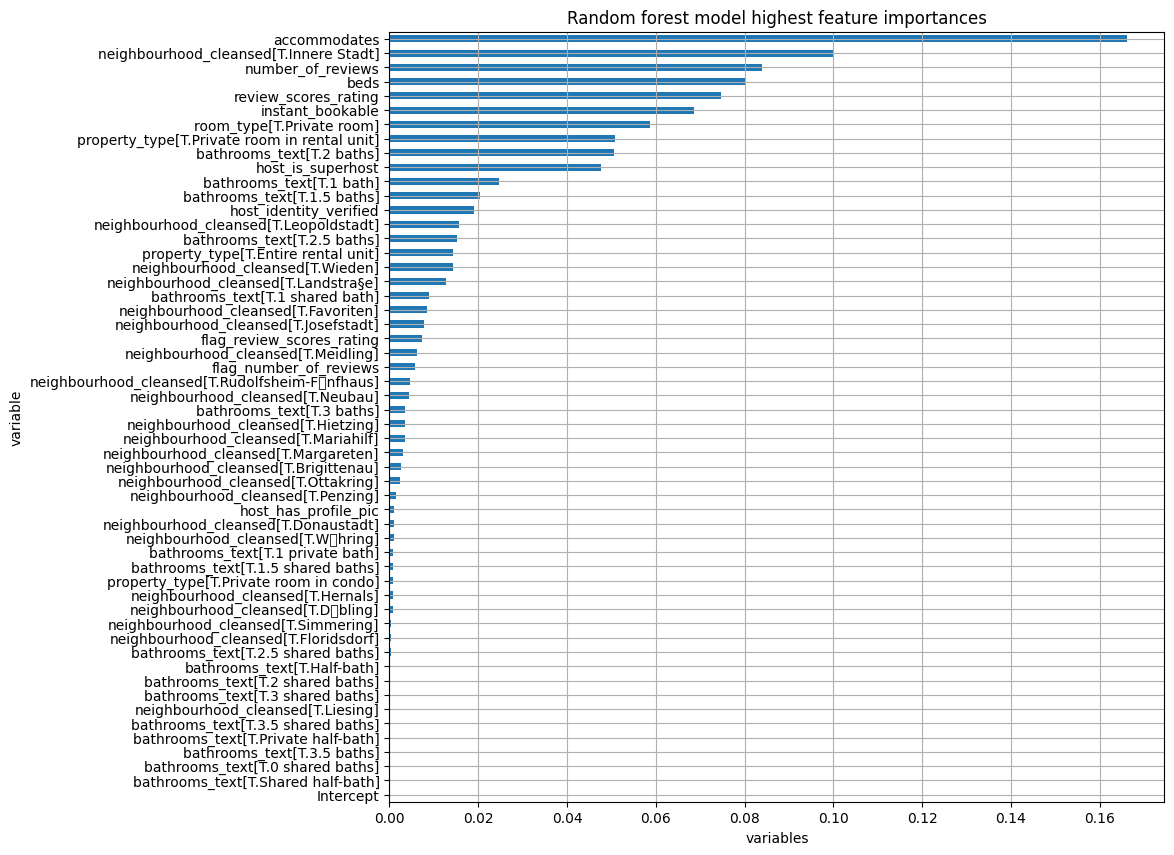

In [153]:
df_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,10), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

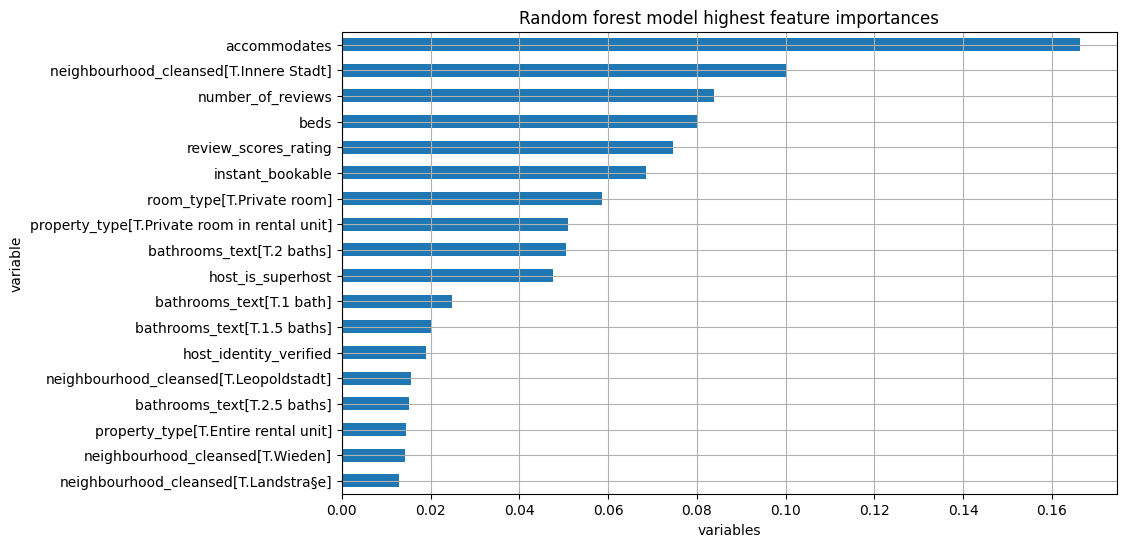

In [154]:
# we only care for variables with an importance of more than 1 pct
cutoff = 0.01

df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

In [155]:
categorical_columns = [
    "property_type",
    "room_type",
    "bathrooms_text",
    "neighbourhood_cleansed",
]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer([
    ("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [156]:
%%time
rf_pipeline.fit(data_train[predictors_2],data_train.price)

CPU times: total: 2.94 s
Wall time: 2.95 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['property_type', 'room_type',
                                                   'bathrooms_text',
                                                   'neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['accommodates', 'beds',
                                                   'number_of_reviews',
                                                   'flag_number_of_reviews',
                                                   'review_scores_rating',
                                                   'flag_review_scores_rating',
                                                   'host_is_superhost',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'instant_bookable'])])),
                ('regressor',
                 RandomForestRegressor(max_features=12, min_samples_leaf=5,
                                       random_state=20240129))])

In [157]:
%%time
result = permutation_importance(
    rf_pipeline,
    data_holdout[predictors_2],
    data_holdout.price,
    n_repeats=10,
    random_state=45,
)

CPU times: total: 6.47 s
Wall time: 6.45 s


In [158]:
pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)

,0
accommodates,0.019428
beds,0.004684
property_type,0.004765
room_type,0.010412
bathrooms_text,0.013737
neighbourhood_cleansed,0.026140
number_of_reviews,0.002821
flag_number_of_reviews,-0.000298
review_scores_rating,0.003089
flag_review_scores_rating,0.000189


In [159]:
grouped = [
    "accommodates",
    "beds",
    "property_type",
    "room_type",
    "bathrooms_text",
    "neighbourhood_cleansed",
]

df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .loc[grouped]\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()

df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,neighbourhood_cleansed,2.6%,2.6%
1,accommodates,1.9%,4.6%
2,bathrooms_text,1.4%,5.9%
3,room_type,1.0%,7.0%
4,property_type,0.5%,7.4%
5,beds,0.5%,7.9%


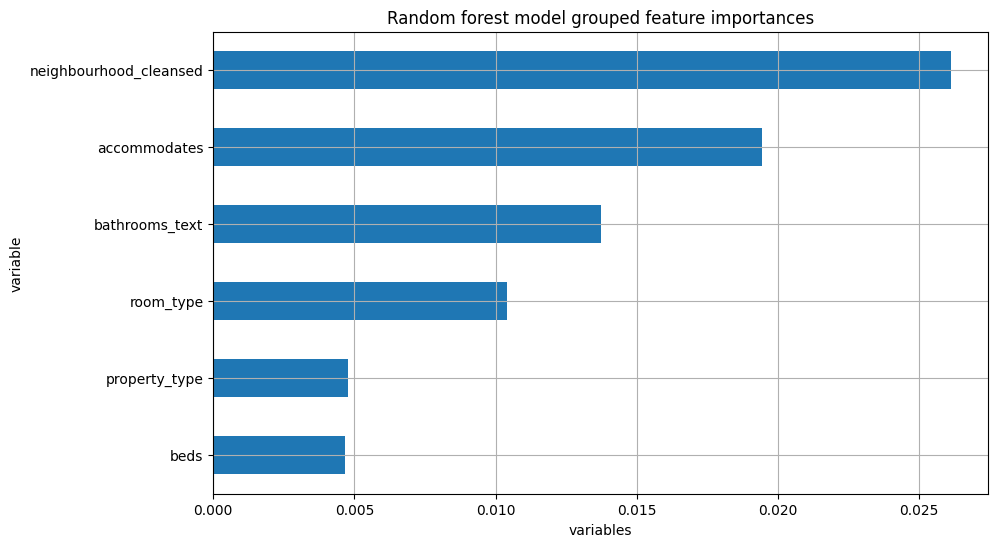

In [160]:
df_grouped_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model grouped feature importances', 
          xlabel = 'variables', legend = False
         );

In [161]:
df_clean_varimp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)

df_clean_varimp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_clean_varimp[df_clean_varimp.cumulative_imp < 0.91]

,variable,imp,cumulative_imp
0,neighbourhood_cleansed,0.026140,0.166279
1,accommodates,0.019428,0.266492
2,instant_bookable,0.014524,0.350408
3,bathrooms_text,0.013737,0.430588
4,room_type,0.010412,0.505201
5,host_is_superhost,0.007963,0.573786
6,property_type,0.004765,0.632425
7,beds,0.004684,0.683333
8,host_identity_verified,0.003219,0.733870
9,review_scores_rating,0.003089,0.781551


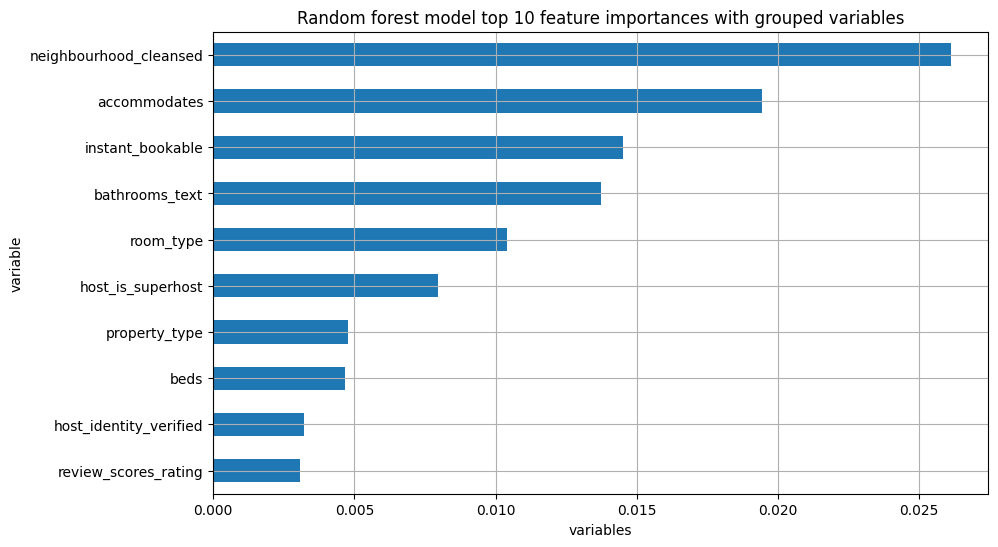

In [162]:
df_clean_varimp.iloc[0:10]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model top 10 feature importances with grouped variables', 
          xlabel = 'variables', legend = False
         );

In [163]:
accomodates_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["accommodates"], kind="average"
)

accomodates_pdp

{'grid_values': [array([2, 3, 4, 5, 6], dtype=int64)],
 'values': [array([2, 3, 4, 5, 6], dtype=int64)],
 'average': array([[ 76.3403338 ,  77.10753571,  92.06993558,  99.19907922,
         130.03371673]])}

In [164]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    )

,number of accomodates,average price
0,2,76.340334
1,3,77.107536
2,4,92.069936
3,5,99.199079
4,6,130.033717


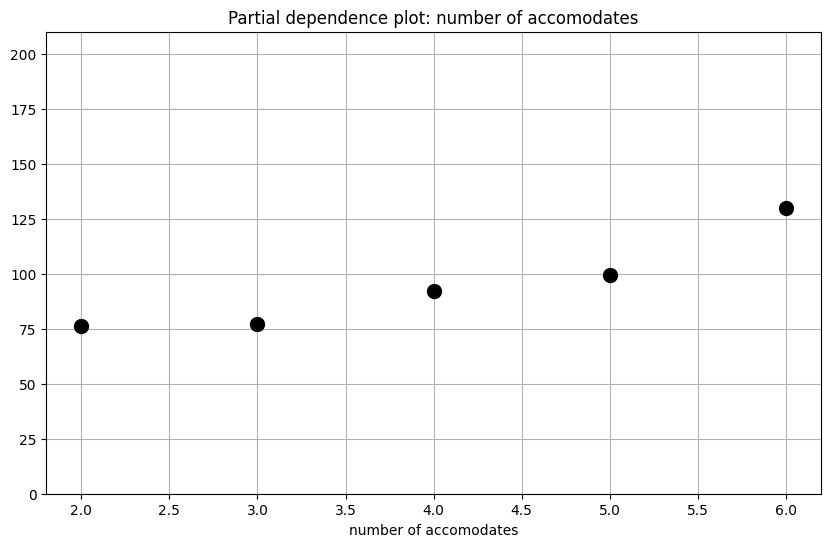

In [165]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'number of accomodates', y = 'average price', ylim = (0, 210), 
    title = 'Partial dependence plot: number of accomodates'
);

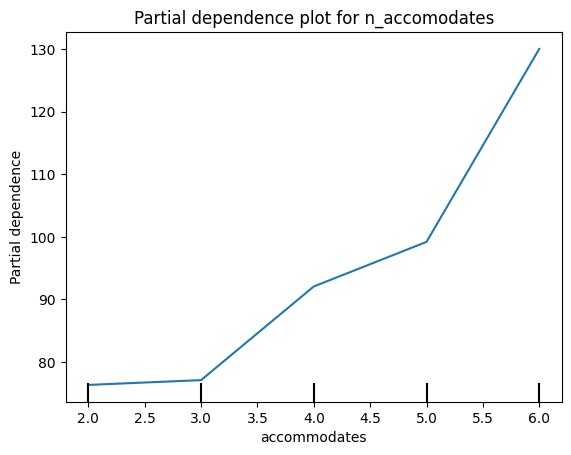

In [166]:
display = PartialDependenceDisplay(
    pd_results = [accomodates_pdp],
    features = [(0,)], 
    feature_names = data_holdout[predictors_2].columns.tolist(), 
    target_idx = 0,
    deciles = {0: np.linspace(2, 6, num=5)}
)
display.plot()
plt.title('Partial dependence plot for n_accomodates')
plt.show();

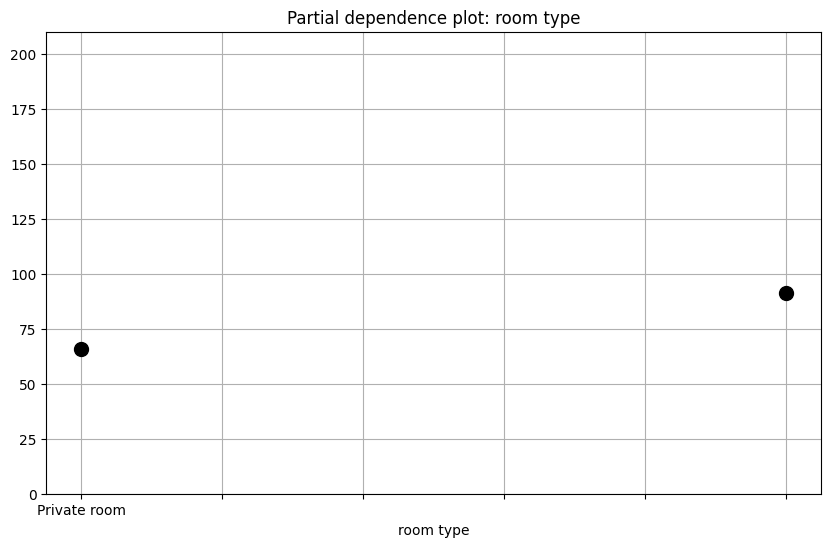

In [167]:
roomtype_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["room_type"], kind="average"
)

pd.DataFrame(
    {'room type': roomtype_pdp['values'][0], 
     'average price': roomtype_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'room type', y = 'average price', ylim = (0, 210), 
    title = 'Partial dependence plot: room type'
);

# LASSO

In [168]:
lasso_model =  ElasticNet(l1_ratio = 1, fit_intercept = True)

lasso_model_cv = GridSearchCV(
    lasso_model,
    # {"alpha":[i/100 for i in range(1, 26, 1)]}, > this option takes forever to run
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)

In [169]:
%%time
lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ......................alpha=0.05;, score=-65.934 total time=   0.0s
[CV 2/5] END ......................alpha=0.05;, score=-70.113 total time=   0.0s
[CV 3/5] END ......................alpha=0.05;, score=-62.629 total time=   0.0s
[CV 4/5] END ......................alpha=0.05;, score=-68.096 total time=   0.0s
[CV 5/5] END ......................alpha=0.05;, score=-71.300 total time=   0.0s
[CV 1/5] END .......................alpha=0.1;, score=-65.486 total time=   0.0s
[CV 2/5] END .......................alpha=0.1;, score=-70.397 total time=   0.0s
[CV 3/5] END .......................alpha=0.1;, score=-62.599 total time=   0.1s
[CV 4/5] END .......................alpha=0.1;, score=-68.364 total time=   0.1s
[CV 5/5] END .......................alpha=0.1;, score=-71.326 total time=   0.0s
[CV 1/5] END ......................alpha=0.15;, score=-65.264 total time=   0.1s
[CV 2/5] END ......................alpha=0.15;, s

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.05, 0.1, 0.15, 0.2, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [170]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

,lasso_coefficient
property_type[T.Entire rental unit],15.149
property_type[T.Private room in rental unit],-26.474
bathrooms_text[T.1 bath],-27.484
bathrooms_text[T.1 private bath],2.299
bathrooms_text[T.1 shared bath],-10.896
...,...
flag_review_scores_rating,-11.668
host_is_superhost,25.397
host_identity_verified,22.147
instant_bookable,25.098


In [171]:
lasso_model_cv.best_estimator_

ElasticNet(alpha=0.05, l1_ratio=1)

In [172]:
lasso_model_cv.cv_results_

{'mean_fit_time': array([0.10698214, 0.14105625, 0.205054  , 0.08417511, 0.05784264]),
 'std_fit_time': array([0.02755478, 0.04179138, 0.04720879, 0.01975063, 0.00638924]),
 'mean_score_time': array([0.0011385 , 0.00178976, 0.00093088, 0.00104647, 0.00099664]),
 'std_score_time': array([2.82246250e-04, 7.46444860e-04, 1.26449501e-04, 7.28775674e-05,
        1.97987933e-06]),
 'param_alpha': masked_array(data=[0.05, 0.1, 0.15, 0.2, 0.25],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.05},
  {'alpha': 0.1},
  {'alpha': 0.15},
  {'alpha': 0.2},
  {'alpha': 0.25}],
 'split0_test_score': array([-65.93430392, -65.48591805, -65.26402365, -65.11506848,
        -65.02271468]),
 'split1_test_score': array([-70.11318567, -70.39731828, -70.48673855, -70.5628512 ,
        -70.5539069 ]),
 'split2_test_score': array([-62.62924506, -62.5986444 , -62.57814833, -62.62597604,
        -62.63892946]),
 'split3_test_score

In [173]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

67.61450620821667